# Notes

For analysing the salary, only use the entries from people that are professional developers.

Data that will probably have an influence on the salary:
- EdLevel
- YearsCode
- YearsCodePro
- OrgSize
- Age

Data that might be interesting to analyse if it has an effect on the salary:
- Employment: should be quite clear, but could be still interesting (although most are probably not professionals then)
- RemoteWork: very interesting, if that has an effect on the salary, but we have to be very careful
- DevType: would be very interesting to see how the differences are between different developer fields
- Country: how much are the differences in the countries? could be very interesting
- LanguageHaveWorkedWith: are there specific languages with that people have a higher salary?
- Gender: are there still differences in men/women/others?
- Ethnicity: are there differences in ethnicities within one country?

What is already analysed by other people?
- Salary by language 2021 vs 2022 (https://www.kaggle.com/code/edgarp95/ranking-stackoverflow-2021-vs-2022)
- Salary by country, by experience, by education level, by number of languages known (https://www.kaggle.com/code/do1likethis/which-devs-get-paid-more-and-why) -> we have to watch out that we differ in this analysis by a guy on kaggle, as it is quite similar to what we are doing
- Gender pay gap (https://www.kaggle.com/code/dima806/genderpaygap-stackoverflowdevelopersurvey2022)
- Salary by country, by dev type, by dev type and country (https://www.kaggle.com/code/ahmetkayapnar/exp-data-analysis-stackoverflow-developers-2022)
- "Key factors for developer salaries in 2022" (https://medium.com/mlearning-ai/key-factors-for-developer-salaries-in-2022-lessons-from-the-stack-overflow-survey-ec5bb99f3f79)

What I think we should analyse:
- The main leading question would be "How is the salary of a developer affected and what makes a high salary?".
- We should start with cleaning up the data (improving the content, but also filtering out faulty datasets (NaN's, impossible salary, etc.).
- For analysing the salary I think we should start with the most obviously like EdLevel, YearsCodePro, OrgSize and Age. Just a small plot to see what the effects are, to then go deeper into it. Those will most likely already be analysed by a dozen other people, but it is necessary that we not leave it out.
- Then go into 1 or 2 interesting questions that were not directly done before. (f.e. country together with gender/ethnicity)
- Alternatively we cna also then make a specific hypothesis like "high salary developers are dominated by man" and then go deeper into that. And then also do a hypothesis test on it.
- After that analysis a Linear Regression (or similar prediction) would be good (maybe only for data of the USA or Germany) and then get the coefficients.



Allgemeine research question mit datenaufbereitung, datenanalyse und logistische Regression
danach hypothesen test auf ein spezielles attribut

###  leitende Forschungsfrage
- Wie wird der Gehalt eines Developers beeinflusst und was macht ein hoher Gehalt aus?
- Welches Attribut beeinflusst das Gehalt am meisten?

### Inhalte des Berichts
- Vorstellen der Forschungsfrage und die Motivation dahinter
- Vorstellung des Datensatzes (z.B. Limitationen)
- Vorstellung der Methoden (Regression und evtl. Hypothesentest)
- Ergebnis der Regression
- Diskussion der Attribute
- ...

### Inhalte vom Jupyter Notebook
- Datenaufbereitung
- Datenanalyse
- Regressionen etc.
- NN

### Ideen
- LinReg mit einem Attribut starten, dann auf weitere Attribute erweitern und dann anschauen, welches Attribut den meisten Einfluss hat
- Neuronales Netz am Ende noch (dann aber whsl. keinen Hypothesentest)
- LinReg mit Attributen auf verschiedene Länder (oder z.B. auch Gender) anschauen

### Fragen
- Können wir eine Linear Regression machen, obwohl wir fast nur kategorischen Daten machen? Bzw. wie machen wir das?
	- one hot encoden oder embedden
- Wie würden wir den Hypothesentest machen? Wir haben jetzt keine direkte Hypothese und dann müssten wir aus den vorherigen Untersuchungen im Bericht noch eine formulieren.
- Hypothesentest ist vom Umfang her noch fragwürdig

# Imports

In [445]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from typing import Optional

In [446]:
# Read data from the csv file
df_raw = pd.read_csv('./data/survey_results_public.csv', sep=',')
df_raw

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,...,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,215232.0
4,5,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Stack Overflow;O...,NaN,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73263,73264,I am a developer by profession,"Employed, full-time",Fully remote,Freelance/contract work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Technical documentation;Blogs;Written Tutorial...,Udemy,8,...,30-60 minutes a day,Less than 15 minutes a day,Just right,DevOps function;Microservices;Developer portal...,Yes,Yes,Yes,Too long,Easy,NaN
73264,73265,I am a developer by profession,"Employed, full-time",Full in-person,Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,Coursera;Udemy;Udacity,6,...,15-30 minutes a day,60-120 minutes a day,Very long,None of these,No,Yes,Yes,Too long,Easy,NaN
73265,73266,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby;School or academic work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Technical documentation;Programming Games;Stac...,Udemy;Codecademy;Pluralsight;edX,42,...,30-60 minutes a day,60-120 minutes a day,Just right,None of these,No,No,No,Appropriate in length,Easy,NaN
73266,73267,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;On the job training,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN


# Helper functions

In [447]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

def ridge_plot(df_ridge_plot, x_label: str, y_label: str, row_order: Optional[list[str]]):
    # Initialize the FacetGrid object
    # pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df_ridge_plot, row=y_label, row_order=row_order, hue=y_label, aspect=15, height=.5)#, palette=pal, )

    # Draw the densities in a few steps
    g.map(sns.kdeplot, x_label, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, x_label, clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,ha="left", va="center", transform=ax.transAxes)

    g.map(label, 'Salary')

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

def calc_scores(estimators, x_test, y_test) -> (list, list, list, list, list):
    """
    Calculates the scores from multiple estimators. For example of cross validations.

    :param estimators: list of estimators
    :param x_test: x test split
    :param y_test: y test split
    :return: quadruple of list of the scores
    """
    r2_scores = []
    mae_scores =  []
    mape_scores = []
    rmse_scores = []
    max_scores = []
    for estimator in estimators:
        predictions = estimator.predict(x_test)
        r2_scores.append(metrics.r2_score(y_test, predictions))
        mae_scores.append(metrics.mean_absolute_error(y_test, predictions))
        mape_scores.append(metrics.mean_absolute_percentage_error(y_test, predictions))
        rmse_scores.append(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
        max_scores.append(metrics.max_error(y_test, predictions))

    return r2_scores, mae_scores, mape_scores, rmse_scores, max_scores

# Data cleaning

In [448]:
# select only those columns that are important for this analysis
df = df_raw.copy()
df = df[['ConvertedCompYearly', 'EdLevel', 'YearsCode', 'YearsCodePro', 'OrgSize', 'Age', 'MainBranch', 'RemoteWork', 'DevType', 'Country', 'LanguageHaveWorkedWith', 'Gender', 'Ethnicity']]

# rename columns
df = df.rename(columns={
    'ConvertedCompYearly':'Salary',
    'MainBranch':'Employment',
    'LanguageHaveWorkedWith':'ProgLanguage'
})

# Replace unnecessarily long entries with shorter ones
df['Employment'] = df['Employment'].replace(
    to_replace=[
        "I am a developer by profession",
        "I am learning to code",
        "I am not primarily a developer, but I write code sometimes as part of my work",
        "I code primarily as a hobby",
        "I used to be a developer by profession, but no longer am",
        "None of these"
    ],
    value=[
        "profession",
        "student",
        "part of work",
        "hobby",
        "ex profession",
        "unknown"
    ]
)

df['EdLevel'] = df['EdLevel'].replace(
    to_replace=[
        "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",
        "Bachelor’s degree (B.A., B.S., B.Eng., etc.)",
        "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",
        "Other doctoral degree (Ph.D., Ed.D., etc.)",
        "Some college/university study without earning a degree",
        "Something else",
        "Professional degree (JD, MD, etc.)",
        "Primary/elementary school",
        "Associate degree (A.A., A.S., etc.)"
    ],
    value=[
        "Secondary school",
        "Bachelor’s degree",
        "Master’s degree",
        "Doctoral degree",
        "University courses",
        "Unknown",
        "Professional degree",
        "Primary school",
        "Associate degree"
    ]
)

df['YearsCode'] = df['YearsCode'].replace(
    to_replace=[
        "More than 50 years",
        "Less than 1 year"
    ],
    value=[
        "50",
        "0",
    ]
)

df['YearsCodePro'] = df['YearsCodePro'].replace(
    to_replace=[
        "More than 50 years",
        "Less than 1 year"
    ],
    value=[
        "50",
        "0",
    ]
)

df['OrgSize'] = df['OrgSize'].replace(
    to_replace=[
        "Just me - I am a freelancer, sole proprietor, etc.",
        "2 to 9 employees",
        "10 to 19 employees",
        "20 to 99 employees",
        "100 to 499 employees",
        "500 to 999 employees",
        "1,000 to 4,999 employees",
        "5,000 to 9,999 employees",
        "10,000 or more employees",
        "I don’t know"
    ],
    value=[
        "1",
        "2 to 9",
        "10 to 19",
        "20 to 99",
        "100 to 499","500 to 999",
        "1,000 to 4,999",
        "5,000 to 9,999",
        "10,000 or more",
        "unknown"
    ]
)

df['RemoteWork'] = df['RemoteWork'].replace(
    to_replace=[
        "Full in-person",
        "Hybrid (some remote, some in-person)",
        "Fully remote"
    ],
    value=[
        "in-person",
        "hybrid",
        "remote"
    ]
)

df['Age'] = df['Age'].replace(
    to_replace=[
        "Under 18 years old",
        "18-24 years old",
        "25-34 years old",
        "35-44 years old",
        "45-54 years old",
        "55-64 years old",
        "65 years or older",
        "Prefer not to say"
    ],
    value=[
        "under 18",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "over 65",
        "unknown"
    ]
)

# Convert the gender values into 'Man', 'Woman', 'Prefer not to say' and 'Other'
df.loc[~df['Gender'].isin(['Man', 'Woman', 'Prefer not to say']), 'Gender'] = "Other"

# Convert columns into numeric values
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce')
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')

# delete all rows with NaN in Salary as those entries can't be used
df = df[df['Salary'].isnull() == False]

df_ger = df.copy()
df_ger = df_ger[df_ger['Country'] == "Germany"]

df_ger

,Salary,EdLevel,YearsCode,YearsCodePro,OrgSize,Age,Employment,RemoteWork,DevType,Country,ProgLanguage,Gender,Ethnicity
25,90647.0,Master’s degree,16.0,9.0,20 to 99,25-34,profession,hybrid,"Developer, back-end;Developer, mobile",Germany,Dart;Go;Java;Kotlin;Swift;TypeScript,Man,White;European
48,106644.0,University courses,40.0,25.0,20 to 99,55-64,profession,hybrid,"Developer, back-end;Developer, desktop or ente...",Germany,Haskell;Java;Rust,Man,European
49,51192.0,Secondary school,7.0,4.0,100 to 499,25-34,profession,remote,"Developer, front-end;Developer, full-stack;Dev...",Germany,C#;HTML/CSS;JavaScript;SQL;TypeScript,Man,White;European
59,63986.0,Bachelor’s degree,4.0,2.0,100 to 499,25-34,profession,hybrid,"Student;Developer, embedded applications or de...",Germany,Assembly;Bash/Shell;C;HTML/CSS;JavaScript;PHP;...,Woman,European
73,63986.0,Bachelor’s degree,10.0,2.0,"10,000 or more",18-24,profession,hybrid,"Developer, full-stack;Developer, QA or test;De...",Germany,Bash/Shell;HTML/CSS;JavaScript;PowerShell;Pyth...,Man,European
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72964,77850.0,Bachelor’s degree,9.0,6.0,100 to 499,25-34,profession,hybrid,"Developer, back-end;Other (please specify):",Germany,Bash/Shell;Kotlin;Scala;SQL,Other,White;European
73009,46923.0,Bachelor’s degree,5.0,4.0,20 to 99,25-34,profession,hybrid,"Developer, front-end;Developer, mobile",Germany,Bash/Shell;F#;Java;JavaScript;Kotlin;Ruby;Rust...,Man,European
73019,42657.0,Master’s degree,12.0,4.0,20 to 99,25-34,profession,hybrid,"Developer, full-stack",Germany,Java;JavaScript;Objective-C;Swift;TypeScript,Man,European
73034,51192.0,Professional degree,35.0,25.0,2 to 9,45-54,profession,in-person,"Developer, full-stack",Germany,Delphi,Man,European


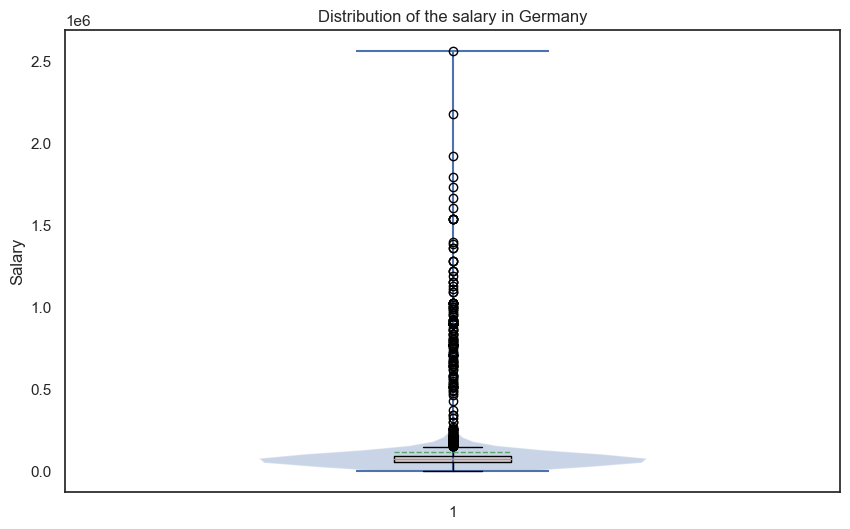

In [449]:
_, ax = plt.subplots(figsize=(10, 6))
ax.violinplot(df_ger['Salary'])
ax.boxplot(df_ger['Salary'], showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set(title='Distribution of the salary in Germany')
plt.show()

In [450]:
print(f"0.925 quantil: {int(np.quantile(df_ger['Salary'], q=0.925)) : >6}")
print(f"0.075 quantil: {int(np.quantile(df_ger['Salary'], q=0.075)) : >6}")

df_ger = df_ger[df_ger['Salary'] < 165414]
df_ger = df_ger[df_ger['Salary'] > 38388]

0.925 quantil: 165414
0.075 quantil:  38388


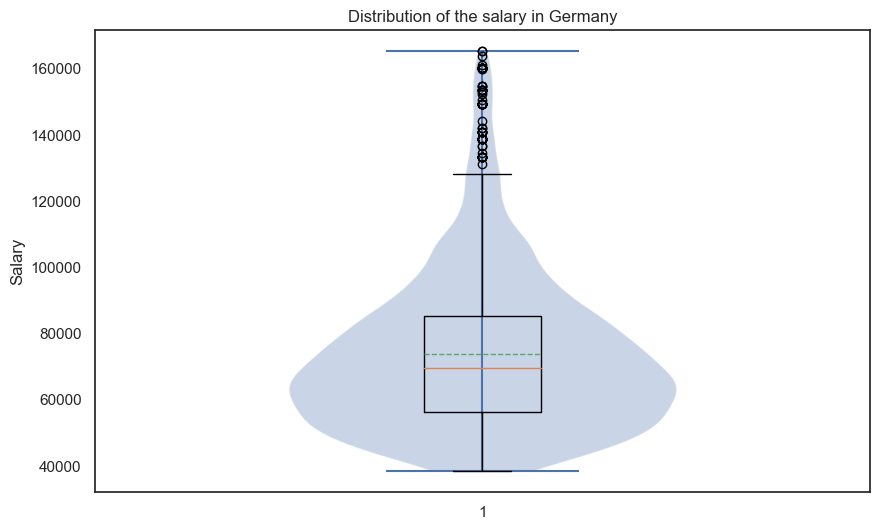

In [451]:
_, ax = plt.subplots(figsize=(10, 6))
ax.violinplot(df_ger['Salary'])
ax.boxplot(df_ger['Salary'], showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set(title='Distribution of the salary in Germany')
plt.show()

                Salary  YearsCode  YearsCodePro
Salary        1.000000   0.382281      0.427430
YearsCode     0.382281   1.000000      0.879357
YearsCodePro  0.427430   0.879357      1.000000


<AxesSubplot: >

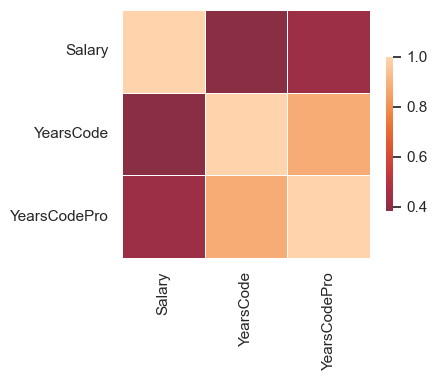

In [452]:
corr = df_ger[['Salary', 'YearsCode', 'YearsCodePro']].corr()
print(corr)
_, heatmap_ax = plt.subplots(figsize=(4, 4))
sns.heatmap(corr, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=heatmap_ax)

There is, as expected, a high correlation between the total years coded and years coded in the profession, so for the prediction of the salary we should only choose one. Additionally, it can be seen, that to the salary there is almost no correlation, so it seems like that the experience of coding in years has almost no effect on the salary.

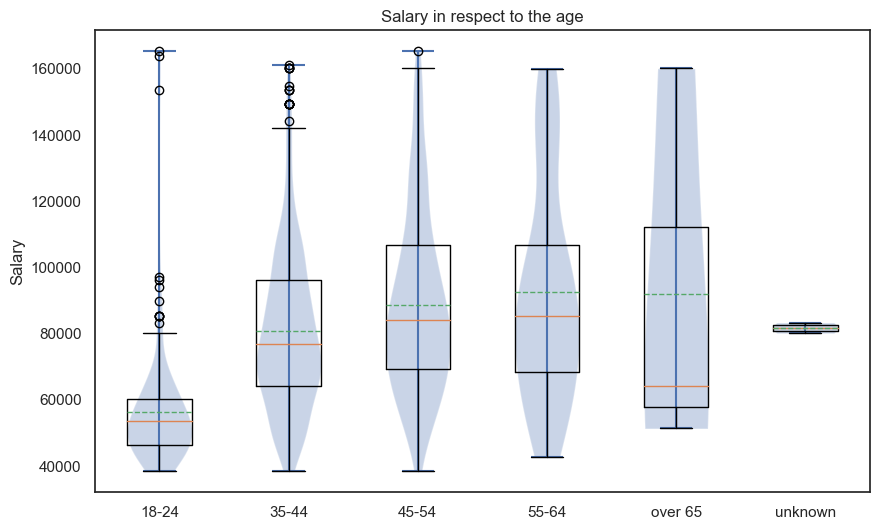

In [453]:
data = [
    df_ger[df_ger['Age'] == "18-24"]['Salary'],
    df_ger[df_ger['Age'] == "35-44"]['Salary'],
    df_ger[df_ger['Age'] == "45-54"]['Salary'],
    df_ger[df_ger['Age'] == "55-64"]['Salary'],
    df_ger[df_ger['Age'] == "over 65"]['Salary'],
    df_ger[df_ger['Age'] == "unknown"]['Salary']
]
labels=["18-24", "35-44", "45-54", "55-64", "over 65", "unknown"]

_, ax = plt.subplots(figsize=(10, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to the age')
plt.show()

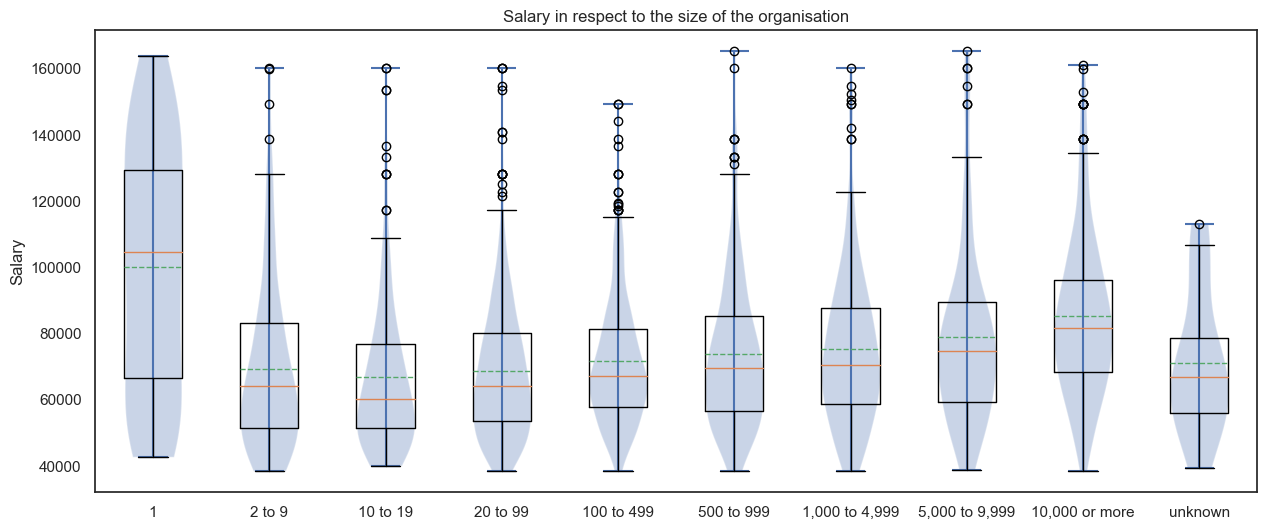

In [454]:
data = [
    df_ger[df_ger['OrgSize'] == "1"]['Salary'],
    df_ger[df_ger['OrgSize'] == "2 to 9"]['Salary'],
    df_ger[df_ger['OrgSize'] == "10 to 19"]['Salary'],
    df_ger[df_ger['OrgSize'] == "20 to 99"]['Salary'],
    df_ger[df_ger['OrgSize'] == "100 to 499"]['Salary'],
    df_ger[df_ger['OrgSize'] == "500 to 999"]['Salary'],
    df_ger[df_ger['OrgSize'] == "1,000 to 4,999"]['Salary'],
    df_ger[df_ger['OrgSize'] == "5,000 to 9,999"]['Salary'],
    df_ger[df_ger['OrgSize'] == "10,000 or more"]['Salary'],
    df_ger[df_ger['OrgSize'] == "unknown"]['Salary']
]
labels=["1", "2 to 9", "10 to 19", "20 to 99", "100 to 499", "500 to 999", "1,000 to 4,999", "5,000 to 9,999", "10,000 or more", "unknown"]

_, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to the size of the organisation')
plt.show()

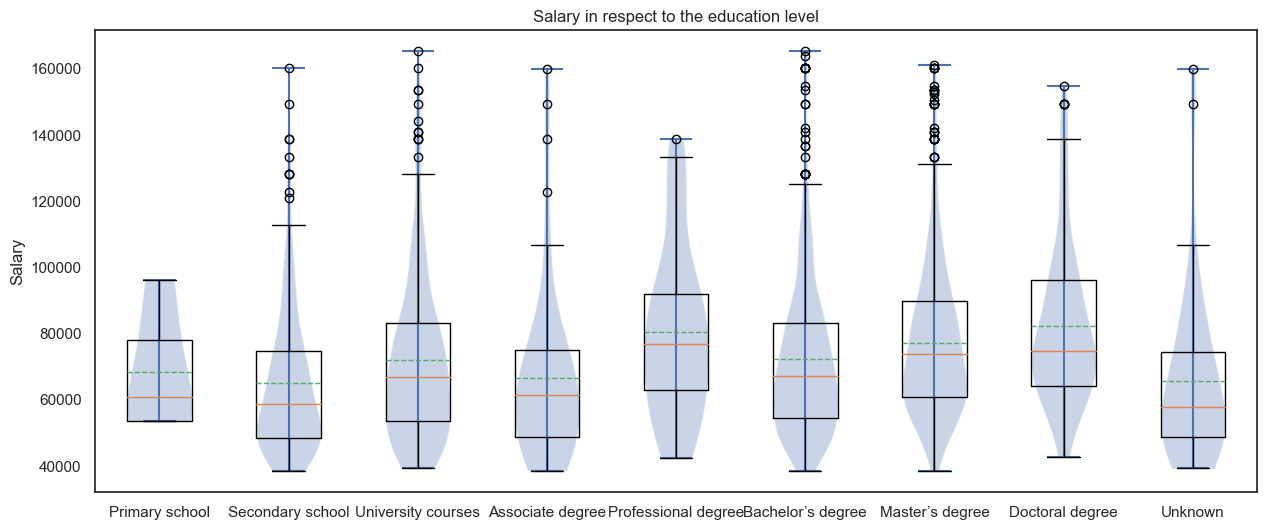

In [455]:
data = [
    df_ger[df_ger['EdLevel'] == "Primary school"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Secondary school"]['Salary'],
    df_ger[df_ger['EdLevel'] == "University courses"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Associate degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Professional degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Bachelor’s degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Master’s degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Doctoral degree"]['Salary'],
    df_ger[df_ger['EdLevel'] == "Unknown"]['Salary']
]
labels=["Primary school","Secondary school","University courses","Associate degree","Professional degree","Bachelor’s degree","Master’s degree","Doctoral degree","Unknown"]

_, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to the education level')
plt.show()

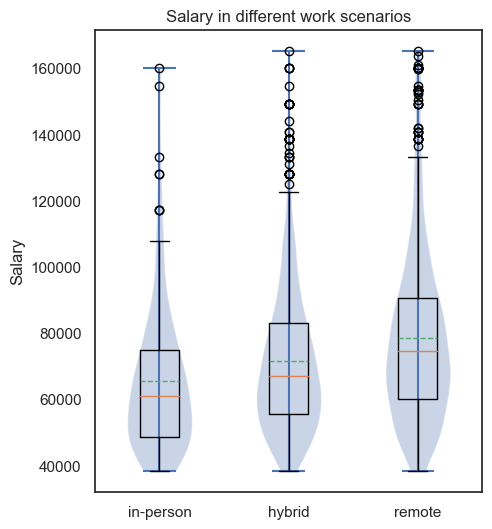

In [456]:
data = [
    df_ger[df_ger['RemoteWork'] == "in-person"]['Salary'],
    df_ger[df_ger['RemoteWork'] == "hybrid"]['Salary'],
    df_ger[df_ger['RemoteWork'] == "remote"]['Salary']
]
labels=["in-person","hybrid","remote"]

_, ax = plt.subplots(figsize=(5, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in different work scenarios')
plt.show()

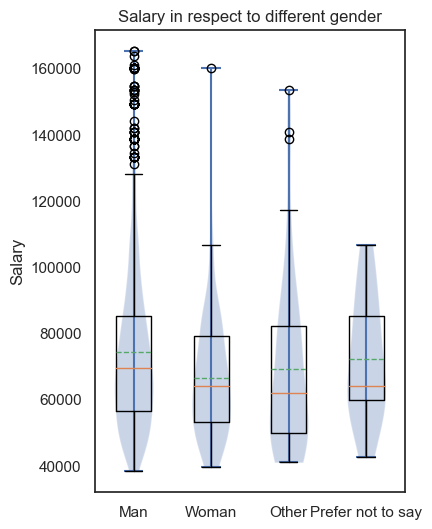

In [457]:
data = [
    df_ger[df_ger['Gender'] == "Man"]['Salary'],
    df_ger[df_ger['Gender'] == "Woman"]['Salary'],
    df_ger[df_ger['Gender'] == "Other"]['Salary'],
    df_ger[df_ger['Gender'] == "Prefer not to say"]['Salary']
]
labels=["Man", "Woman", "Other", "Prefer not to say"]

_, ax = plt.subplots(figsize=(4, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to different gender')
plt.show()

In [458]:
#### TOO MANY INDIVIDUAL PROGRAMMING LANGUAGES TO LOOK AT ALL!!

# df_prog = df_usa.copy()
# df_prog = df_prog[df_usa['Salary']<300000]
# df_prog['ProgLanguage'] = df_prog['ProgLanguage'].str.split(';')
# df_prog = df_prog.explode('ProgLanguage')
#
# df_prog['ProgLanguage'].unique()

C:\Users\jonas\AppData\Local\Temp\ipykernel_2880\2851414316.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ridge = df_ridge[df['Salary']<300000]
C:\Users\jonas\anaconda3\envs\ds\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\jonas\anaconda3\envs\ds\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\jonas\anaconda3\envs\ds\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\jonas\anaconda3\envs\ds\lib\site-packages\seaborn\axisgrid.py:118

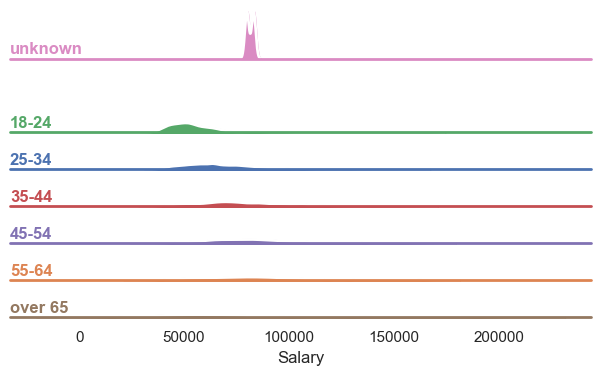

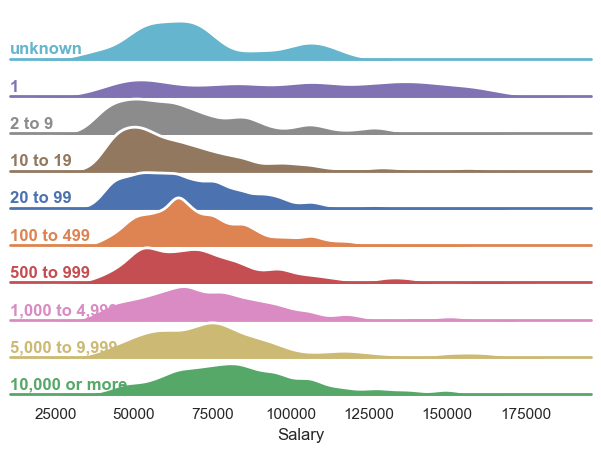

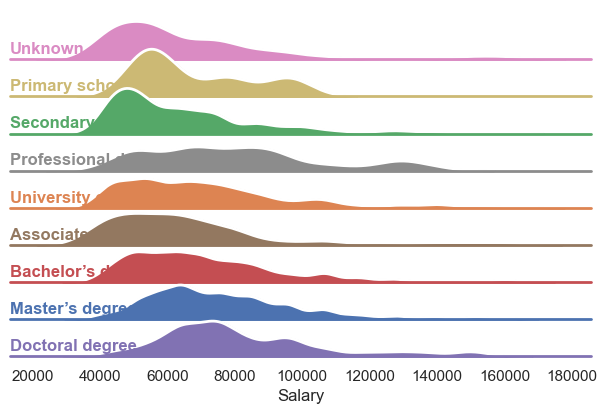

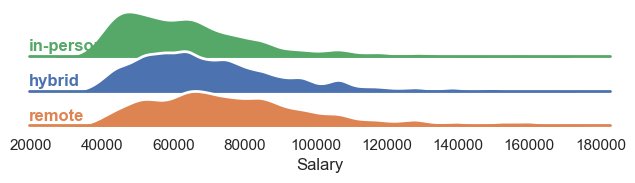

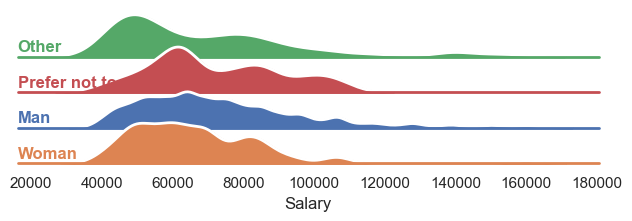

In [459]:
df_ridge = df_ger.copy()
df_ridge = df_ridge[df['Salary']<300000]

ridge_plot(df_ridge[['Salary', 'Age']], y_label='Age', x_label='Salary', row_order=["unknown","under 18","18-24","25-34","35-44","45-54","55-64","over 65"])
ridge_plot(df_ridge[['Salary', 'OrgSize']], y_label='OrgSize', x_label='Salary', row_order=["unknown","1","2 to 9","10 to 19","20 to 99","100 to 499","500 to 999","1,000 to 4,999","5,000 to 9,999","10,000 or more"])
ridge_plot(df_ridge[['Salary', 'EdLevel']], y_label='EdLevel', x_label='Salary', row_order=["Unknown","Primary school","Secondary school","Professional degree","University courses","Associate degree","Bachelor’s degree","Master’s degree","Doctoral degree"])
ridge_plot(df_ridge[['Salary', 'RemoteWork']], y_label='RemoteWork', x_label='Salary', row_order=['in-person', 'hybrid', 'remote'])
ridge_plot(df_ridge[['Salary', 'Gender']], y_label='Gender', x_label='Salary', row_order=['Other', 'Prefer not to say', 'Man', 'Woman'])

# Regression

In [561]:
df_reg = df_ger.copy()

# delete all rows where coding is not their profession
df_reg = df_reg[df_reg['Employment'] == 'profession']

# select important features
df_reg = df_reg[['Salary', 'EdLevel', 'YearsCode', 'OrgSize', 'Age', 'RemoteWork', 'ProgLanguage', 'DevType']]

df_reg['Age'] = df_reg['Age'].replace(
    to_replace=[
        "unknown",
        "under 18",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "over 65",
    ],
    value=[
        None,
        1,
        2,
        3,
        4,
        5,
        6,
        7
    ]
)
df_reg['OrgSize'] = df_reg['OrgSize'].replace(
    to_replace=[
        "unknown",
        "1",
        "2 to 9",
        "10 to 19",
        "20 to 99",
        "100 to 499",
        "500 to 999",
        "1,000 to 4,999",
        "5,000 to 9,999",
        "10,000 or more"
    ],
    value=[
        None,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9
    ]
)

# one hot encoding 'EdLevel' and 'RemoteWork'; drop first to avoid the dummy variable trap
df_reg = pd.concat([df_reg, pd.get_dummies(df_reg['EdLevel'], drop_first=True)], axis=1)
df_reg = df_reg.drop(['EdLevel', 'Unknown'], axis=1)

df_reg = pd.concat([df_reg, pd.get_dummies(df_reg['RemoteWork'], drop_first=True)], axis=1)
df_reg = df_reg.drop(['RemoteWork'], axis=1)

# one hot encoding 'ProgLanguage' and 'DevType' where with ";" seperated list values
df_reg = pd.concat([df_reg, df_reg['ProgLanguage'].str.get_dummies(sep=';')], axis=1)
df_reg = df_reg.drop(['ProgLanguage'], axis=1)

df_reg = pd.concat([df_reg, df_reg['DevType'].str.get_dummies(sep=';')], axis=1)
df_reg = df_reg.drop(['DevType'], axis=1)

df_reg.apply(pd.to_numeric, errors='ignore')
df_reg = df_reg.dropna()

In [562]:
df_reg

,Salary,YearsCode,OrgSize,Age,Bachelor’s degree,Doctoral degree,Master’s degree,Primary school,Professional degree,Secondary school,...,Engineering manager,Marketing or sales professional,Other (please specify):,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator
25,90647.0,16.0,4.0,3.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,106644.0,40.0,4.0,6.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49,51192.0,7.0,5.0,3.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
59,63986.0,4.0,5.0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
73,63986.0,10.0,9.0,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72964,77850.0,9.0,5.0,3.0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
73009,46923.0,5.0,4.0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73019,42657.0,12.0,4.0,3.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73034,51192.0,35.0,2.0,5.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


,Salary,YearsCode,OrgSize,Age,in-person,remote
Salary,1.000000,0.371255,0.134103,0.350089,-0.106764,0.166078
YearsCode,0.371255,1.000000,-0.011268,0.768008,0.027395,0.085688
OrgSize,0.134103,-0.011268,1.000000,-0.012906,-0.086016,-0.066170
Age,0.350089,0.768008,-0.012906,1.000000,0.024892,0.067345
in-person,-0.106764,0.027395,-0.086016,0.024892,1.000000,-0.213863
remote,0.166078,0.085688,-0.066170,0.067345,-0.213863,1.000000


<AxesSubplot: >

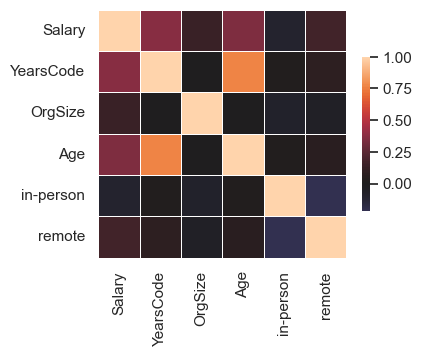

In [563]:
corr = df_reg[['Salary', 'YearsCode', 'OrgSize', 'Age', 'in-person', 'remote']].corr()

display(corr)
_, heatmap_ax = plt.subplots(figsize=(4, 4))
sns.heatmap(corr, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=heatmap_ax)

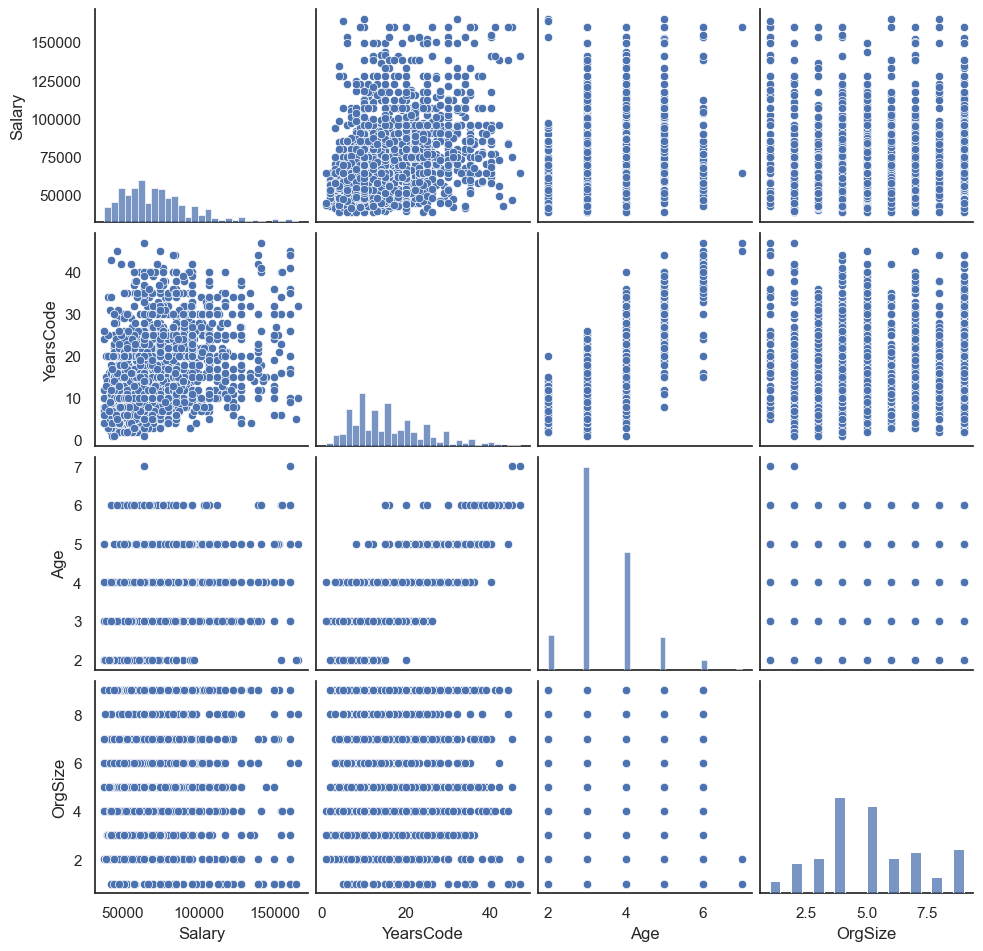

In [564]:
rel = sns.pairplot(df_reg[['Salary', 'YearsCode', 'Age', 'OrgSize']])
rel.fig.subplots_adjust(top=.95)

C:\Users\jonas\anaconda3\envs\ds\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\jonas\anaconda3\envs\ds\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\jonas\anaconda3\envs\ds\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\jonas\anaconda3\envs\ds\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\jon

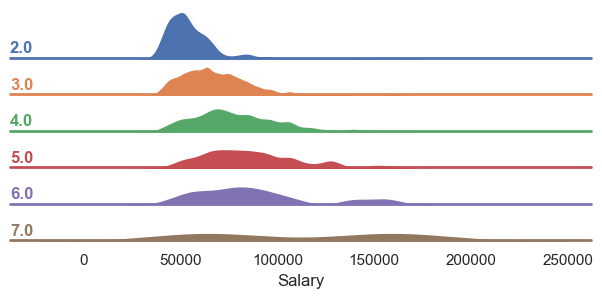

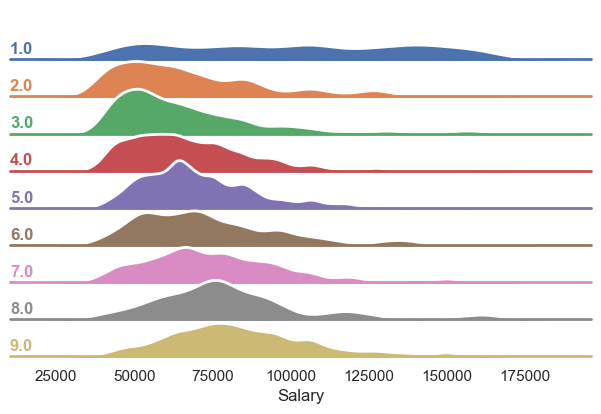

In [565]:
ridge_plot(df_reg[['Salary', 'Age']], y_label='Age', x_label='Salary', row_order=None)
ridge_plot(df_reg[['Salary', 'OrgSize']], y_label='OrgSize', x_label='Salary', row_order=None)

In [566]:
df_reg.columns

Index(['Salary', 'YearsCode', 'OrgSize', 'Age', 'Bachelor’s degree',
       'Doctoral degree', 'Master’s degree', 'Primary school',
       'Professional degree', 'Secondary school', 'University courses',
       'in-person', 'remote', 'APL', 'Assembly', 'Bash/Shell', 'C', 'C#',
       'C++', 'COBOL', 'Clojure', 'Crystal', 'Dart', 'Delphi', 'Elixir',
       'Erlang', 'F#', 'Fortran', 'Go', 'Groovy', 'HTML/CSS', 'Haskell',
       'Java', 'JavaScript', 'Julia', 'Kotlin', 'LISP', 'Lua', 'MATLAB',
       'OCaml', 'Objective-C', 'PHP', 'Perl', 'PowerShell', 'Python', 'R',
       'Ruby', 'Rust', 'SAS', 'SQL', 'Scala', 'Solidity', 'Swift',
       'TypeScript', 'VBA', 'Academic researcher', 'Blockchain',
       'Cloud infrastructure engineer', 'Data or business analyst',
       'Data scientist or machine learning specialist',
       'Database administrator', 'Designer', 'DevOps specialist',
       'Developer, QA or test', 'Developer, back-end',
       'Developer, desktop or enterprise applicatio

In [583]:
# x = df_reg[['YearsCode', 'Age', 'OrgSize', 'in-person', 'remote']]

# x = df_reg[['YearsCode', 'OrgSize', 'Age', 'Bachelor’s degree','Doctoral degree', 'Master’s degree', 'Primary school','Professional degree', 'Secondary school', 'University courses','in-person', 'remote']]

# x = df_reg[['YearsCode', 'OrgSize', 'Age', 'Bachelor’s degree','Doctoral degree', 'Master’s degree', 'Primary school','Professional degree', 'Secondary school', 'University courses','in-person', 'remote', 'APL', 'Assembly', 'Bash/Shell', 'C', 'C#','C++', 'COBOL', 'Clojure', 'Crystal', 'Dart', 'Delphi', 'Elixir','Erlang', 'F#', 'Fortran', 'Go', 'Groovy', 'HTML/CSS', 'Haskell','Java', 'JavaScript', 'Julia', 'Kotlin', 'LISP', 'Lua', 'MATLAB','OCaml', 'Objective-C', 'PHP', 'Perl', 'PowerShell', 'Python', 'R','Ruby', 'Rust', 'SAS', 'SQL', 'Scala', 'Solidity', 'Swift','TypeScript', 'VBA']]

x = df_reg[['YearsCode', 'OrgSize', 'Age', 'Bachelor’s degree','Doctoral degree', 'Master’s degree', 'Primary school','Professional degree', 'Secondary school', 'University courses','in-person', 'remote', 'APL', 'Assembly', 'Bash/Shell', 'C', 'C#','C++', 'COBOL', 'Clojure', 'Crystal', 'Dart', 'Delphi', 'Elixir','Erlang', 'F#', 'Fortran', 'Go', 'Groovy', 'HTML/CSS', 'Haskell','Java', 'JavaScript', 'Julia', 'Kotlin', 'LISP', 'Lua', 'MATLAB','OCaml', 'Objective-C', 'PHP', 'Perl', 'PowerShell', 'Python', 'R','Ruby', 'Rust', 'SAS', 'SQL', 'Scala', 'Solidity', 'Swift','TypeScript', 'VBA', 'Academic researcher', 'Blockchain','Cloud infrastructure engineer', 'Data or business analyst','Data scientist or machine learning specialist','Database administrator', 'Designer', 'DevOps specialist','Developer, QA or test', 'Developer, back-end','Developer, desktop or enterprise applications','Developer, embedded applications or devices', 'Developer, front-end','Developer, full-stack', 'Developer, game or graphics','Developer, mobile', 'Educator', 'Engineer, data','Engineer, site reliability', 'Engineering manager','Marketing or sales professional', 'Other (please specify):','Product manager', 'Project manager', 'Scientist','Security professional', 'Senior Executive (C-Suite, VP, etc.)','Student', 'System administrator']]

y = df_reg['Salary']

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x), index=x.index, columns=x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
folds = KFold(n_splits=10, shuffle=True, random_state=100)

In [584]:
x

,YearsCode,OrgSize,Age,Bachelor’s degree,Doctoral degree,Master’s degree,Primary school,Professional degree,Secondary school,University courses,...,Engineering manager,Marketing or sales professional,Other (please specify):,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator
25,0.326087,0.375,0.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,0.847826,0.375,0.8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.130435,0.500,0.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,0.065217,0.500,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73,0.195652,1.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72964,0.173913,0.500,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73009,0.086957,0.375,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73019,0.239130,0.375,0.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73034,0.739130,0.125,0.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


R2:   0.25
MAE:  15151
MAPE: 0.215
RMSE: 20564
MAX:  102075


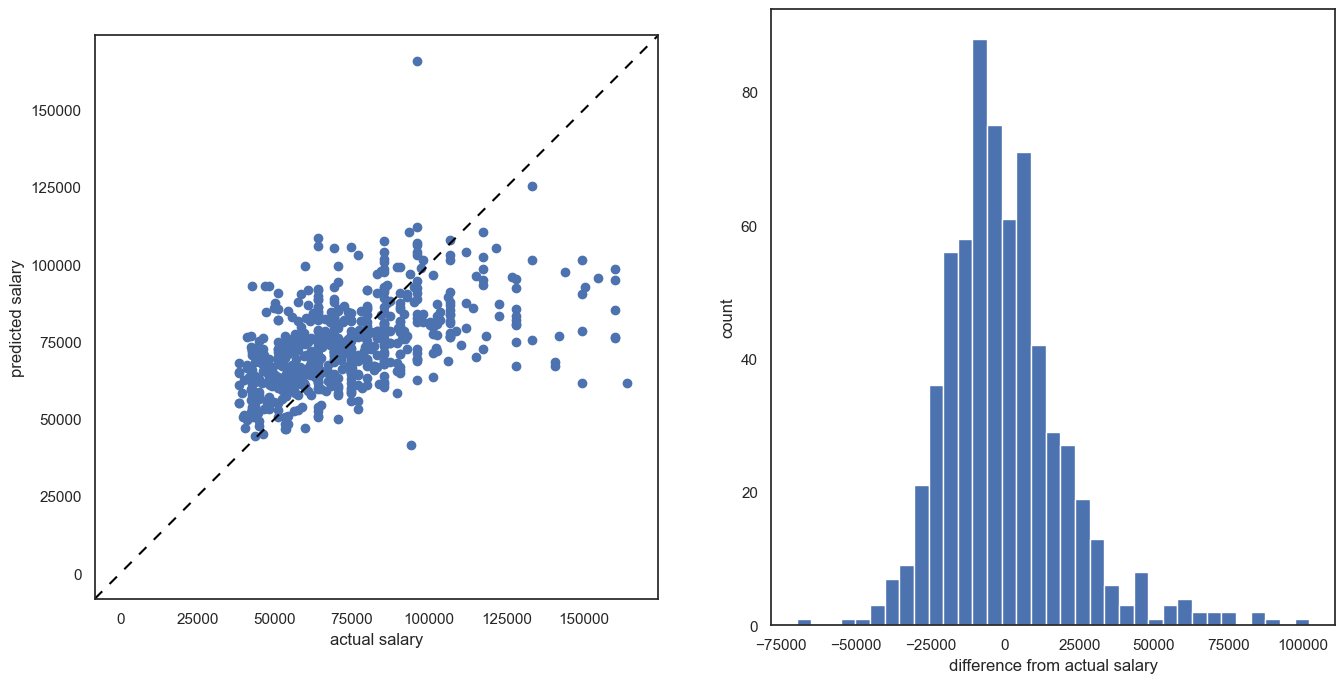

In [585]:
lm = LinearRegression()
lm.fit(x_train, y_train)
prediction_linear = lm.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([lm], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_linear)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_linear), bins=35)
plt.show()

In [586]:
lm_cv = LinearRegression()
estimators = cross_validate(lm_cv, x_train, y_train, cv=folds, return_estimator=True)['estimator']
r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores(estimators, x_test, y_test)
print('R2   (cross validated):', np.round(np.mean(r2_scores), 3))
print('MAE  (cross validated):', np.mean(mae_scores).astype(int))
print('MAPE (cross validated):', np.round(np.mean(mape_scores), 3))
print('RMSE (cross validated):', np.mean(rmse_scores).astype(int))
print('MAX  (cross validated):', np.max(max_scores).astype(int))
print('\nR2   (splits):', np.round(r2_scores, 3))
print('MAE  (splits):', list(map(round, mae_scores)))
print('MAPE (splits):', np.round(mape_scores, 3))
print('RMSE (splits):', list(map(round, rmse_scores)))
print('MAX  (splits):', list(map(round, max_scores)))

R2   (cross validated): 0.242
MAE  (cross validated): 15231
MAPE (cross validated): 0.216
RMSE (cross validated): 20670
MAX  (cross validated): 104841

R2   (splits): [0.239 0.254 0.246 0.242 0.252 0.224 0.245 0.243 0.232 0.242]
MAE  (splits): [15231, 15110, 15237, 15182, 15115, 15362, 15250, 15223, 15320, 15283]
MAPE (splits): [0.216 0.214 0.217 0.214 0.215 0.218 0.216 0.216 0.218 0.216]
RMSE (splits): [20710, 20511, 20616, 20665, 20541, 20911, 20626, 20657, 20806, 20667]
MAX  (splits): [103512, 99789, 104079, 100384, 101190, 101521, 100069, 101659, 104036, 104842]


R2:   0.291
MAE:  15143
MAPE: 0.218
RMSE: 19987
MAX:  85807


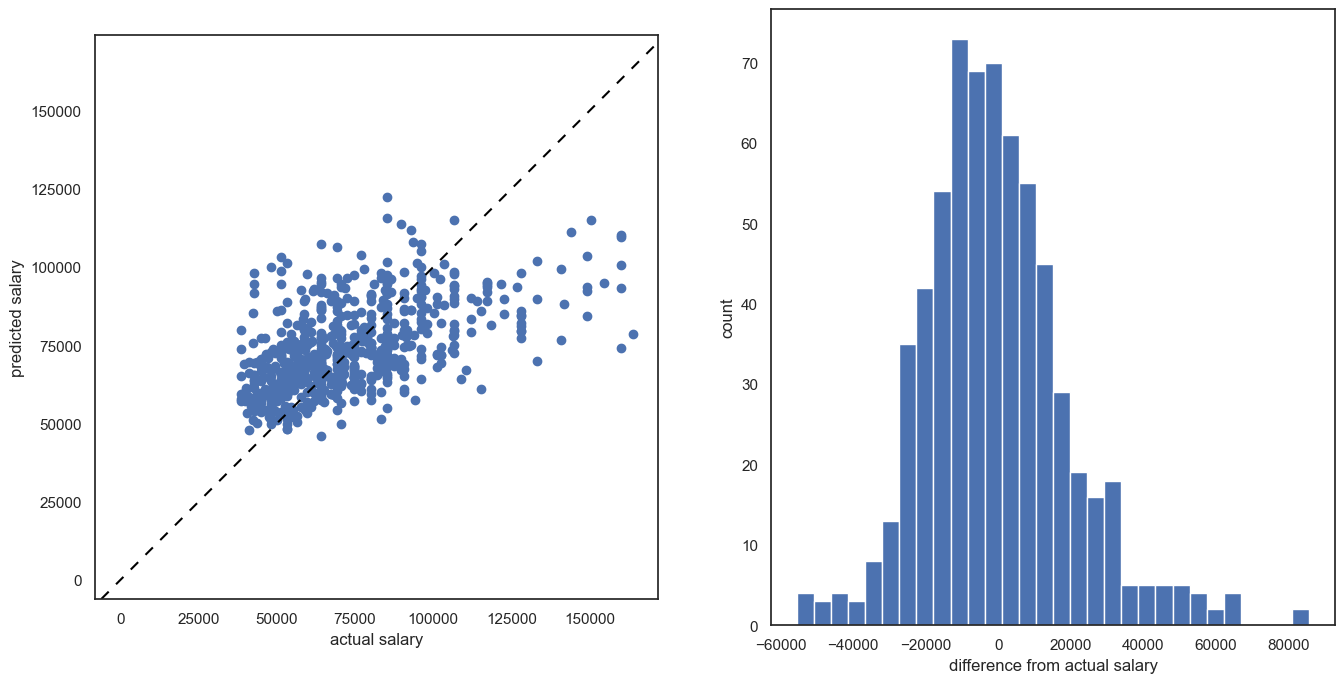

In [587]:
random_regressor = RandomForestRegressor(random_state=1, bootstrap=True)
random_regressor.fit(x_train, y_train)
prediction_rf = random_regressor.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([random_regressor], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_rf)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_rf), bins=30)
plt.show()

R2:   0.328
MAE:  14591
MAPE: 0.211
RMSE: 19468
MAX:  83214


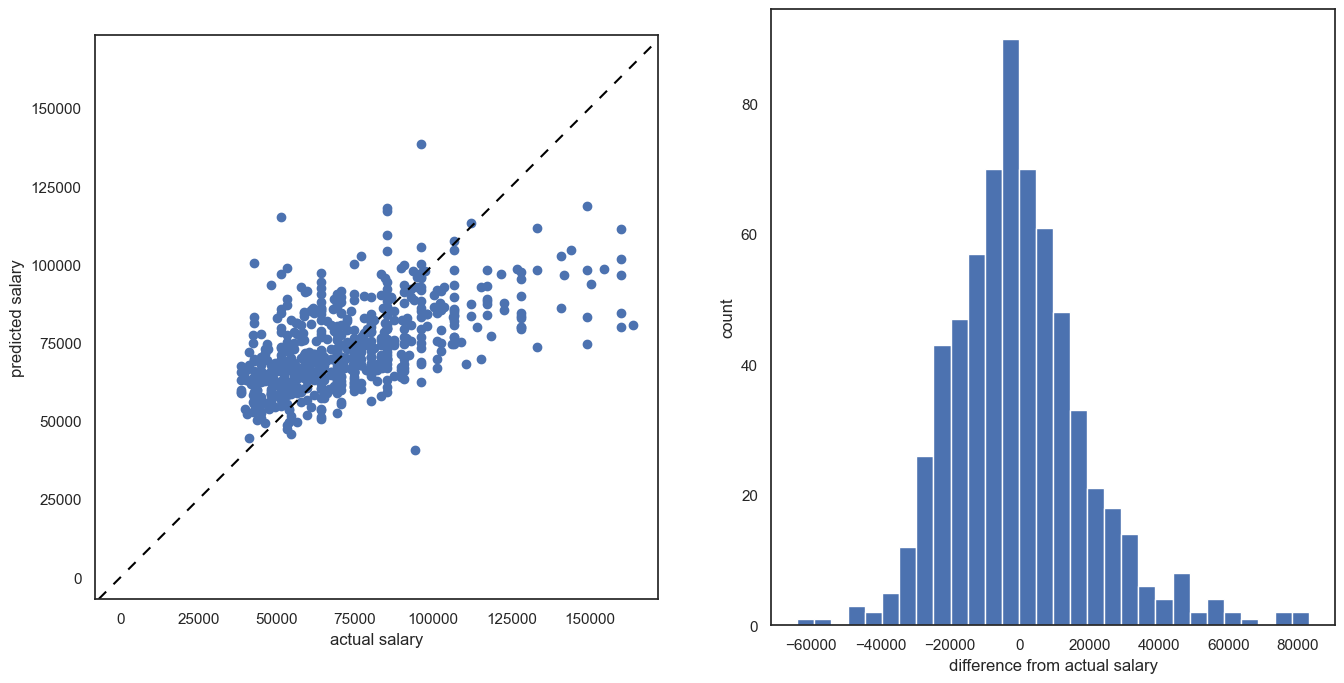

In [588]:
gbt_regressor = GradientBoostingRegressor(random_state=1)
gbt_regressor.fit(x_train, y_train)
prediction_gbt = gbt_regressor.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([gbt_regressor], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_gbt)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_gbt), bins=30)
plt.show()

R2:   0.25
MAE:  15081
MAPE: 0.214
RMSE: 20561
MAX:  102561


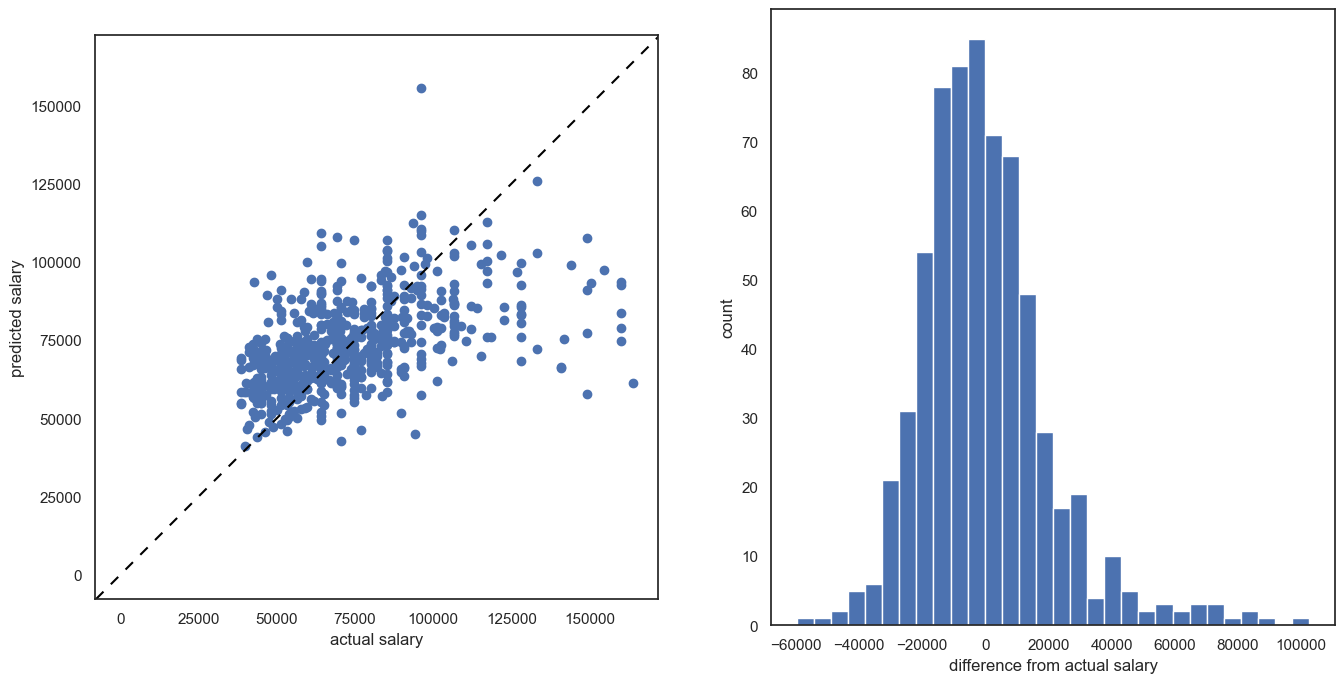

In [589]:
# mlp_regressor = MLPRegressor(random_state=1, max_iter=50000, hidden_layer_sizes=(24, 24, 24), activation='tanh')#, alpha=0.001, tol=1e-100)
mlp_regressor = MLPRegressor(random_state=1, max_iter=2000, hidden_layer_sizes=(24, 24, 24))
mlp_regressor.fit(x_train, y_train)
prediction_mlp = mlp_regressor.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([mlp_regressor], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_mlp)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_mlp), bins=30)
plt.show()

# Helper functions
that I coded in the past (not yet used in here)

In [590]:
def sort_by_mean(y):
    a = y[1:]
    if np.all(np.isnan(a)):
        return np.nan
    return np.nanmean(a)

def get_values(column, key):
    l = []

    for i in range(min(df[column]),max(df[column])+1):
        l.append(df[df[column]==i][key])
    return l

'''Creates the list of Salary values for columns with categorical data'''
def labeled_column_with_price(label):
    # Ignore nan values
    uniques = df[df[label].isnull() == False][label].unique()
    l = []

    for i in uniques:
        l.append((i, df[df[label]==i]['Salary']))

    l.sort(key=sort_by_mean)

    xticks, values = [], []
    for x, y in l:
        xticks.append(x)
        values.append(y)
    return values, xticks